In [182]:
#testing!
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
file1_path = 'educ_data.csv'
file2_path = 'gini_data.csv'
file3_path = 'unemp_data.csv'
file4_path = 'gdppc_data.csv'

educ_df = pd.read_csv(file1_path)
gini_df = pd.read_csv(file2_path)
unemp_df = pd.read_csv(file3_path)
gdppc_df = pd.read_csv(file4_path)

In [183]:
# Clean unemp_df
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']  

year_columns = unemp_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
unemp_df = pd.melt(unemp_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Unemp %')

# Drop rows with no data
unemp_df = unemp_df.dropna(subset=['Unemp %'])

# Convert 'Year' to a numerical type
unemp_df['Year'] = unemp_df['Year'].astype(int)

# Clean educ_df
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']  

year_columns = educ_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
educ_df = pd.melt(educ_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Average years of schooling')

# Drop rows with no data
educ_df = educ_df[educ_df['Average years of schooling'] != '..']

# Convert 'Year' to a numerical type and strip out the text around it
educ_df['Year'] = educ_df['Year'].str.extract('(\d+)').astype(int)

# Clean gini_df

id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']  

year_columns = gini_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
gini_df = pd.melt(gini_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Gini_coefficient')

# Drop rows with no data
gini_df['Gini_coefficient'] = gini_df['Gini_coefficient'].ffill()
gini_df = gini_df.dropna(subset=['Gini_coefficient'])

# Convert 'Year' to a numerical type and strip out the text around it
gini_df['Year'] = gini_df['Year'].astype(int)

gini_df

# Clean GDP Per capita

id_vars = ['Series Name', 'Series Code', 'Country Name', 'Country Code']  

year_columns = gdppc_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
gdppc_df = pd.melt(gdppc_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='GDPPC')

# Drop rows with no data
gdppc_df = gdppc_df.dropna(subset=['GDPPC'])

# Convert 'Year' to a numerical type and strip out the text around it
gdppc_df['Year'] = gdppc_df['Year'].str.extract('(\d+)').astype(int)




In [184]:
unemp_df = unemp_df.drop(columns=['Country Name'])
educ_df = educ_df.drop(columns=['Country Name'])
gdppc_df = gdppc_df.drop(columns=['Country Name'])

merged_df = pd.merge(gini_df,unemp_df,left_on=["Country Code","Year"],right_on=["Country Code","Year"])
merged_df = pd.merge(merged_df,educ_df,left_on=["Country Code","Year"],right_on=["Country Code","Year"])
merged_df = pd.merge(merged_df, gdppc_df,left_on=["Country Code","Year"],right_on=["Country Code","Year"])

columns_req = ['Country Name', 'Country Code', 'Year',
       'GDPPC',
       'Gini_coefficient','Unemp %',
       'Series Name_x','Average years of schooling']

merged_df = merged_df[columns_req]
merged_df = merged_df[merged_df['Series Name_x'].str.contains('both sexes', case=False)]

# Step 2: Drop duplicate rows
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
merged_df = merged_df.set_index(["Country Name","Year"])


## 2. Using the ARIMA model for forecasting inequality
ARIMA is a model used for time series forecasting, and we can use this to forecast inequality in various countries.

In order to find the best model for forecasting, we need to determine the parameters of the ARIMA model, namely:

**p: the number of autoregressive terms**

**d: the number of nonseasonal differences needed for stationarity**

**q: the number of lagged forecast errors in the prediction equation.**

### 2.1. Determining parameter d, the number of nonseasonal differences for stationarity

To use an ARIMA model, we need to ensure that the data is stationary by determining and eliminating seasonality by selecting an appropriate parameter d.

The parameter d is the "degree of differencing", which refers to the number of times a series is differenced. For example, if the series value is X_t, then 1 degree of differencing means the new value X_t' = X_t - X_t-1

We use both Autocorrelation Function (ACF) graphs and Augmented Dicky-Fuller tests to determine the number of differences needed (value of d).

#### 2.1.1 ACF graphs allow us to visualise the autocorrelation and hence seasonality

We will start by doing the analysis on Singapore, before conducting it across all countries.

In [185]:
# Clean gini_df
gini_columns_req = ['Country Name', 'Country Code', 'Year', 'Gini_coefficient']

gini_df_clean = gini_df[gini_columns_req]
gini_df_clean.sort_values(by=['Country Code','Year'],inplace=True)
gini_df_clean = gini_df_clean.drop_duplicates().reset_index(drop=True)
gini_df_clean['Year'] = pd.to_datetime(gini_df_clean['Year'],format='%Y')
gini_df_clean = gini_df_clean.set_index('Year')
gini_df_clean['Gini_coefficient'] = gini_df_clean['Gini_coefficient'].ffill() 

# Create singapore_df
singapore_df = gini_df_clean.loc[gini_df_clean['Country Code'] =='SGP'].copy()
singapore_df.head()

,Country Name,Country Code,Gini_coefficient
Year,,,
1964-01-01,Singapore,SGP,37.6
1965-01-01,Singapore,SGP,38.1
1966-01-01,Singapore,SGP,37.5
1967-01-01,Singapore,SGP,37.8
1968-01-01,Singapore,SGP,26.8


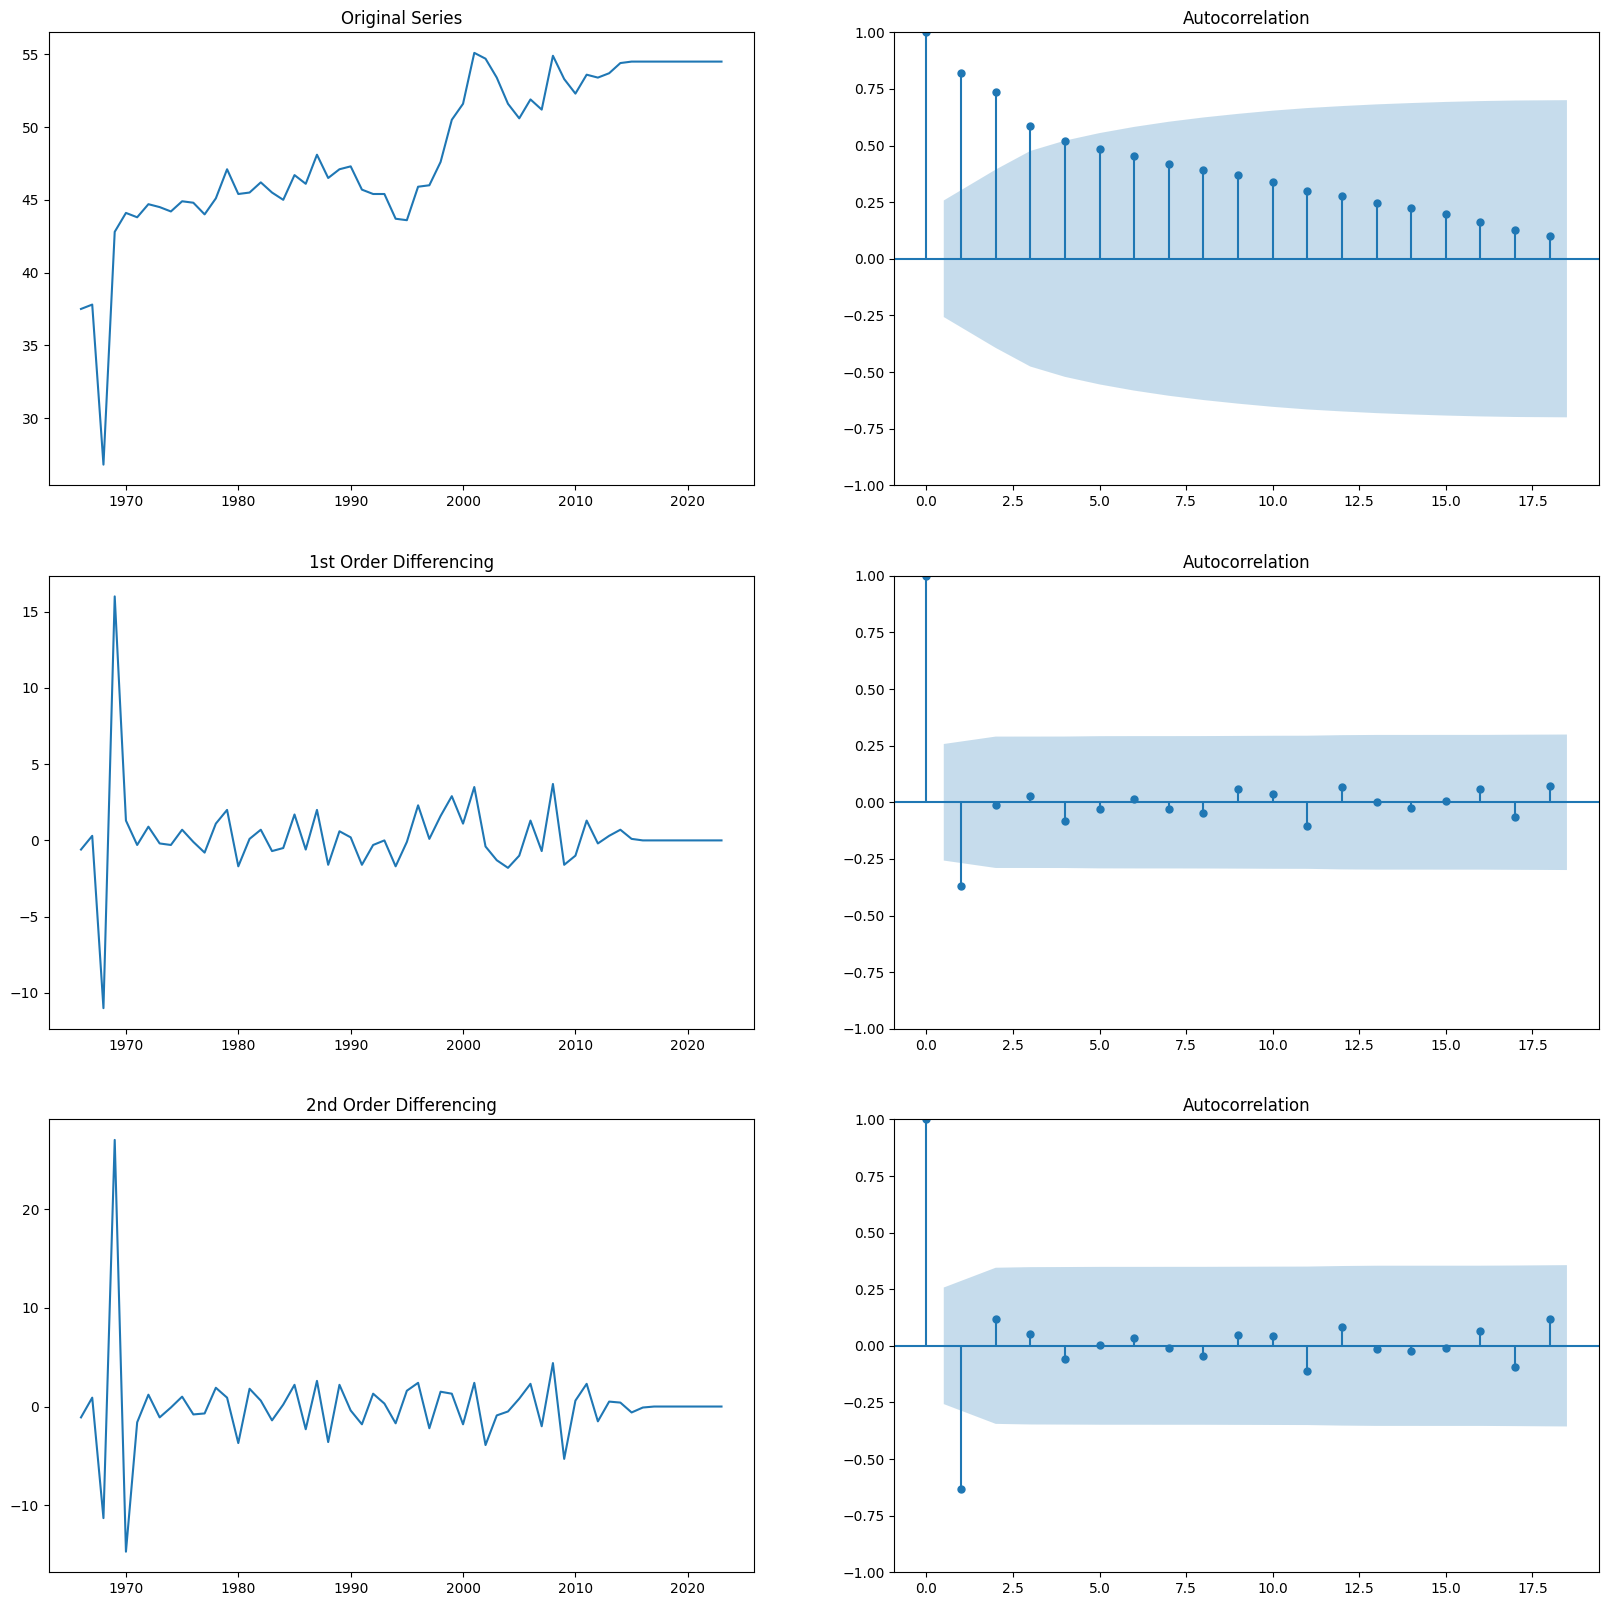

In [186]:
#Plotting ACF graphs

from statsmodels.graphics.tsaplots import plot_acf

# Create dataframes for d = 1 and d = 2 values of gini_recalculated
singapore_df['Gini_coefficient_d1'] = singapore_df['Gini_coefficient'].diff()
singapore_df['Gini_coefficient_d2'] = singapore_df['Gini_coefficient'].diff().diff()
singapore_df.dropna(inplace=True)

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20,20))
axes[0, 0].plot(singapore_df['Gini_coefficient'])
axes[0, 0].set_title('Original Series')
plot_acf(singapore_df['Gini_coefficient'], ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(singapore_df['Gini_coefficient_d1']); axes[1, 0].set_title('1st Order Differencing')
plot_acf(singapore_df['Gini_coefficient_d1'], ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(singapore_df['Gini_coefficient_d2']); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(singapore_df['Gini_coefficient_d2'], ax=axes[2, 1])

plt.show()

The goal of differencing is to reduce autocorrelation trends to obtain stationarity. As seen from the ACF graphs above, d = 0  appears to have a gradual decline on autocorrelation, which is typical when the data is not stationary.

The ACF graph for d = 1 still shows some autocorrelation, but without any trend. Since d = 2 does not change much from d = 1, we will likely use d = 1 to prevent over-differencing.

#### 2.1.2. Augmented Dicky Fuller (ADF) Test
The ADF test is a numerical test for stationarity, to confirm our conclusions from the ACF graph.

In [187]:
#Calculating p-values for Augmented Dicky-Fuller (adfuller) Tests
from statsmodels.tsa.stattools import adfuller

gini_d0 = singapore_df['Gini_coefficient'].tolist()
gini_d1 = singapore_df['Gini_coefficient_d1'].tolist()
gini_d2 = singapore_df['Gini_coefficient_d2'].tolist()

print('The p-value of adfuller test for d = 0 is:', adfuller(gini_d0)[1])
print('The p-value of adfuller test for d = 1 is:', adfuller(gini_d1)[1])
print('The p-value of adfuller test for d = 2 is:', adfuller(gini_d2)[1])


The p-value of adfuller test for d = 0 is: 0.14151210242213347
The p-value of adfuller test for d = 1 is: 1.0386584273900933e-19
The p-value of adfuller test for d = 2 is: 1.4763994422251605e-19


Since the p-value of the adfuller test is << 0.01 for d = 1, we will use d = 1 in our ARIMA model, which supports our initial hypothesis from the ACF graphs.

### 2.2. Determining the other ARIMA parameters (p and q)
In this section, we determine the number of autoregressive terms (p), and the number of lagged forecast errors  (q)

In [188]:
# Firstly, we split the data into train and test data: We are using 80% of data as training data
# We do not randomise the train & test data as we are comparing the forecast (from the train data) with the test data
# Hence, the test data will have to come chronologically after the train data
# The order of the data is important for time-series analysis

train=singapore_df[:int((80*len(singapore_df))/100)]["Gini_coefficient"]
test=singapore_df[int((80*len(singapore_df))/100):]["Gini_coefficient"]

print('Total data points:', len(singapore_df))
print('Training data points:',len(train))
print('Testing data points:',len(test))

Total data points: 58
Training data points: 46
Testing data points: 12


In [189]:
#Find all combinations of p, d and q through iteration

from statsmodels.tsa.arima.model import ARIMA
import itertools

p = range(0,10) # We selected the maximum value of p to be 10 to prevent overfitting
q = range(0,10) # We selected the maximum value of q to be 10 to prevent overfitting
d = 1

pdq_combination=list(itertools.product(p,[d],q)) # Determined earlier that d=1
pdq_combination # See all the iterations

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (3, 1, 8),
 (3, 1, 9),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (4, 1, 8),
 (4, 1, 9),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (5, 1, 8),
 (5, 1, 9),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (6, 1, 8),
 (6, 1, 9),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7),
 (7, 1, 8),
 (7, 1, 9),
 (8, 1, 0),
 (8, 1, 1),
 (8, 1, 2),
 (8,

#### 2.2.1 Using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to determine the best ARIMA model

The AIC and BIC are ways to 'score' the ARIMA models - essentially, the ARIMA model with the lowest AIC/BIC (either one) will be the best model for forecasting.

In [190]:
import warnings
warnings.filterwarnings('ignore')

#Creating lists to store the values of AIC, BIC & respective (p,d,q) combinations
aic=[]
bic=[]
pdqCombs=[]


#This loop will try every combination of (p,d,q) in ARIMA models and calculate the AIC & BIC
for pdq in pdq_combination:
    model=ARIMA(train,order=pdq).fit()
    pred=model.predict(start=len(train),end=(len(singapore_df)-1))
    model_aic=model.aic
    model_bic=model.bic
    pdqCombs.append(pdq)
    aic.append(model_aic)
    bic.append(model_bic) 


In [191]:
#Put the results into a dataframe

results = pd.DataFrame(index=pdqCombs, data=aic, columns=['AIC'])
results['BIC']=bic
results

,AIC,BIC
"(0, 1, 0)",234.601401,236.408064
"(0, 1, 1)",229.489829,233.103154
"(0, 1, 2)",231.489532,236.909519
"(0, 1, 3)",233.449478,240.676128
"(0, 1, 4)",234.065311,243.098624
...,...,...
"(9, 1, 5)",249.491149,276.591086
"(9, 1, 6)",251.287983,280.194583
"(9, 1, 7)",251.569110,282.282372
"(9, 1, 8)",251.357735,283.877659


In [192]:
# Since AIC < BIC, we will use the p,d,q values for the index with the lowest AIC
print(results[['AIC']].min())
print(results[['BIC']].min())

AIC    229.489829
dtype: float64
BIC    233.103154
dtype: float64


In [193]:
#To find the index - the p,d,q values - that give the lowest AIC values
establishedmodel=results['AIC'].idxmin()
establishedmodel # (p,d,q) values

(0, 1, 1)

#### 2.2.2 Training the model and plotting prediction against actual values

In [194]:
# Train the ARIMA model with the (p,d,q) obtained for the lowest AIC, (4,1,0)
model=ARIMA(train,order=establishedmodel).fit()

In [195]:
# Predict the values of the gini coefficient for the duration of the test data
pred=model.predict(start=len(train),end=(len(singapore_df)-1))

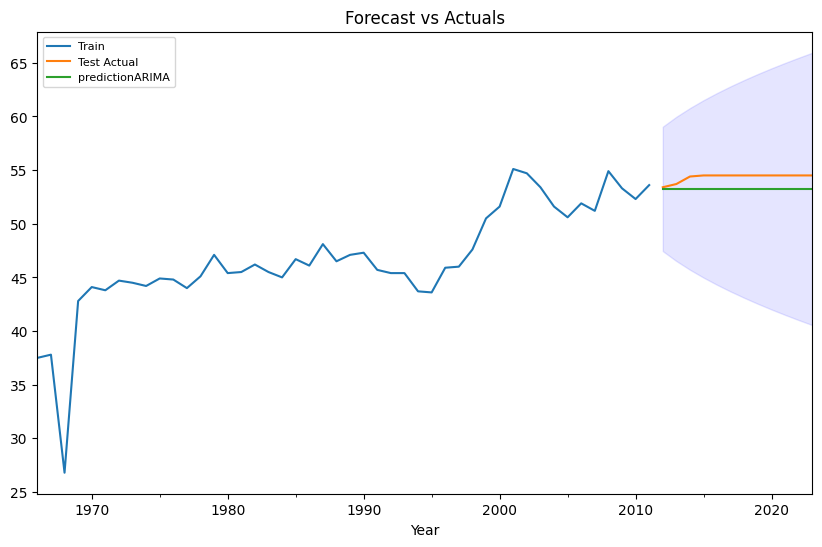

In [196]:
#Plot graphs
train.plot(legend=True, label='Train', figsize=(10,6)) # Plot train data
test.plot(legend=True, label='Test Actual') # Plot test data
pred.plot(legend=True, label='predictionARIMA') # Plot predicted values

#Calculate and plot confidence intervals
forecasts=model.get_forecast(len(test)) #95% confidence interval
ci=forecasts.conf_int()
lower_series = pd.Series(ci.loc[:,'lower Gini_coefficient'])
upper_series = pd.Series(ci.loc[:,'upper Gini_coefficient'])

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='b', alpha=.1)

#Title and legend
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 2.3 Repeating across all countries

In [197]:
best_pdq_dic = {}

def arima_country_predictions(gini_df_clean, country, ax):
    """
    Fits an ARIMA model for each country's Gini coefficient data and plots predictions.
    
    Parameters:
    - gini_df_clean: DataFrame containing Gini coefficient and year data for each country.
    - country: Country of choice
    - ax: axes to plot on
    """
    country_df = gini_df_clean.loc[gini_df_clean['Country Name'] == country]
    # Determine the order of differencing (d) needed for stationarity
    d = 0
    country_df_diffed = country_df.copy()
    while True:
        p_value = adfuller(country_df_diffed['Gini_coefficient'].dropna().tolist())[1]
        if p_value <= 0.05:
            break
        country_df_diffed['Gini_coefficient'] = country_df_diffed['Gini_coefficient'].diff().dropna()
        d += 1

    # Train-test split
    train = country_df[:int(0.8 * len(country_df))]['Gini_coefficient']
    test = country_df[int(0.8 * len(country_df)):]['Gini_coefficient']

    # Define ranges for p and q, with d fixed
    p = range(0, 6)  # Reduced range for faster search
    q = range(0, 6)
    pdq_combinations = list(itertools.product(p, [d], q))

    # Store AIC, BIC, and parameters
    aic = []
    bic = []
    pdqCombs = []

    # Evaluate models and store AIC/BIC values
    for pdq in pdq_combinations:
        try:
            model = ARIMA(train, order=pdq).fit()
            aic.append(model.aic)
            bic.append(model.bic)
            pdqCombs.append(pdq)
        except Exception as e:
            print(f"Skipping model {pdq} for {country} due to error: {e}")
            continue

    # Collect results into DataFrame
    results = pd.DataFrame(index=pdqCombs, data=aic, columns=['AIC'])
    results['BIC'] = bic

    # Check if results DataFrame is empty (i.e., no valid models)
    if results.empty or (results['AIC'] == float('inf')).all():
        print(f"No valid models for {country}. Skipping.")
        return

    # Select the best model based on AIC or BIC
    min_aic = results['AIC'].min()
    min_bic = results['BIC'].min()
    if min_aic < min_bic:
        best_pdq = results['AIC'].idxmin()
    else:
        best_pdq = results['BIC'].idxmin()

    best_pdq_dic[country] = best_pdq

    # Fit the best model and make predictions
    model = ARIMA(train, order=best_pdq).fit()
    pred = model.predict(start=len(train), end=len(country_df) - 1)

    # Plotting
    train.plot(legend=True, label='Train', ax=ax)
    test.plot(legend=True, label='Test Actual', ax=ax)
    pred.plot(legend=True, label='ARIMA Prediction', ax=ax)

    # Confidence intervals
    forecasts = model.get_forecast(len(test))
    ci = forecasts.conf_int()
    lower_series = ci.iloc[:, 0]
    upper_series = ci.iloc[:, 1]

    ax.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=0.1)
    ax.set_title(f"ARIMA Model for {country}")


        

Working on Barbados
Working on Brunei Darussalam
Working on Bhutan
Working on Botswana
Working on Central African Republic
Working on Canada
Working on Central Europe and the Baltics
Working on Switzerland
Working on Channel Islands
Working on Chile
Working on China
Working on Cote d'Ivoire
Working on Cameroon
Working on Congo, Dem. Rep.
Working on Congo, Rep.
Working on Colombia
Working on Comoros
Working on Cabo Verde
Working on Costa Rica
Working on Caribbean small states
Working on Cuba


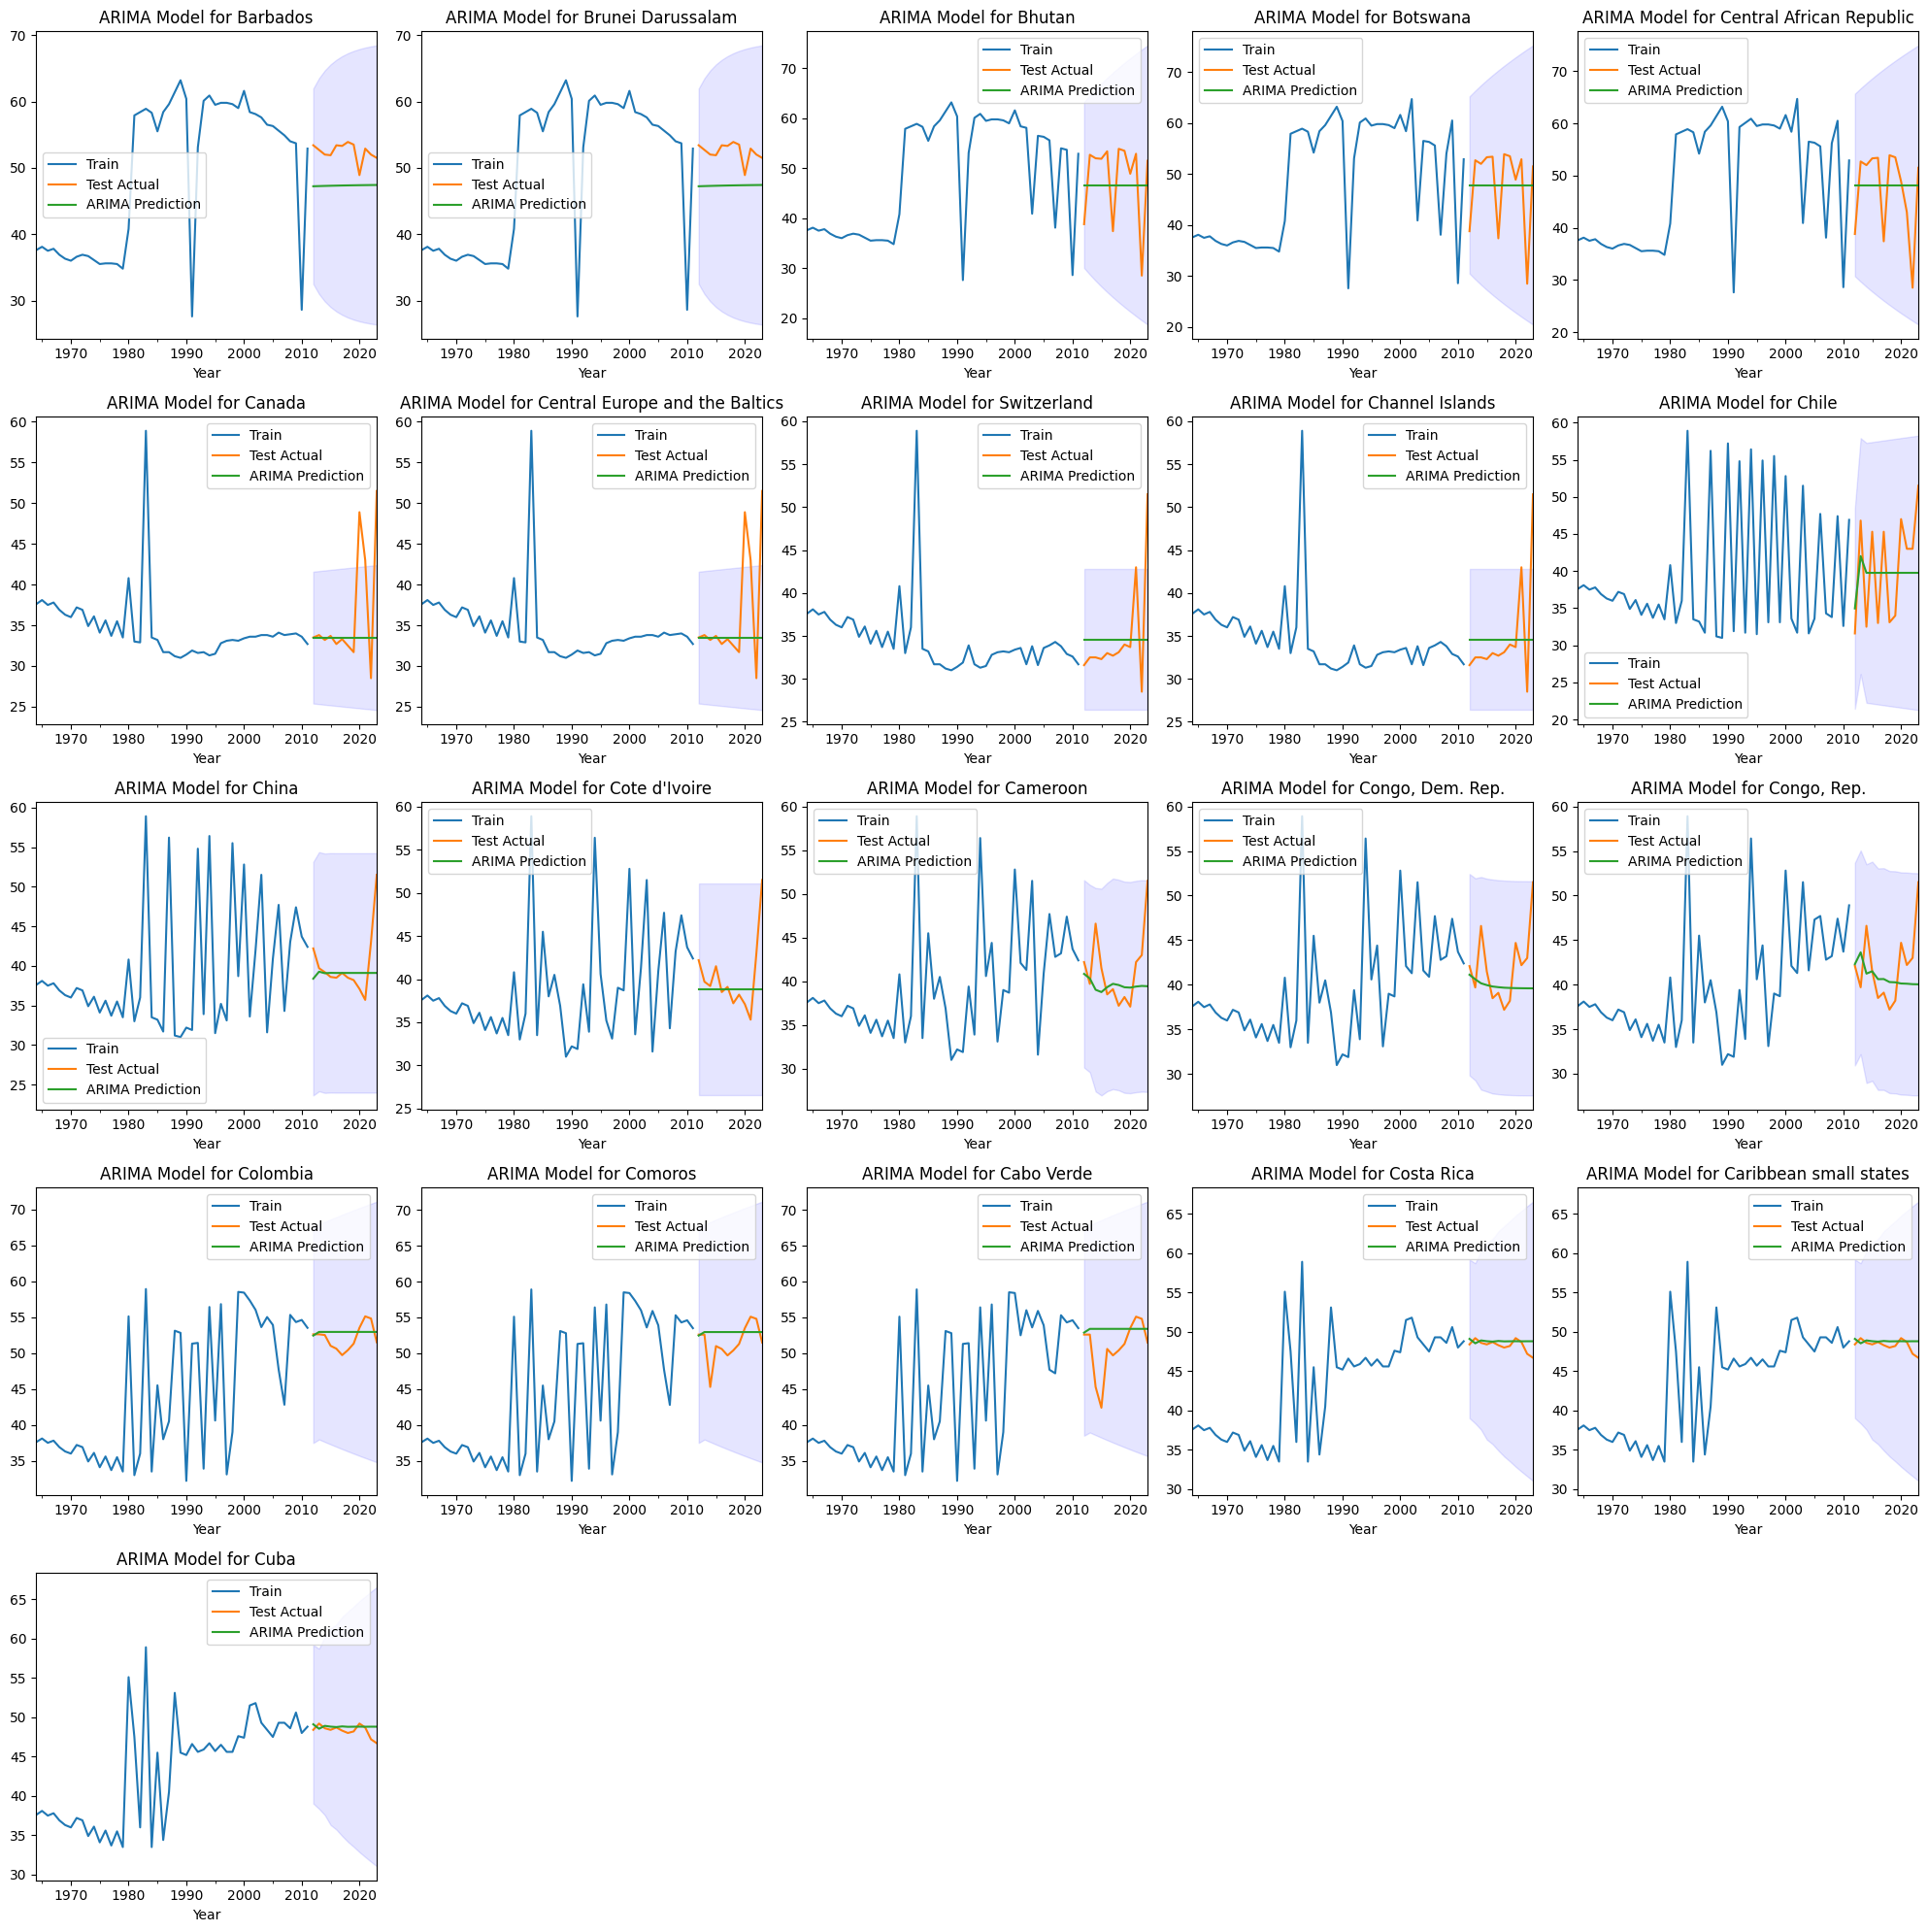

In [198]:
import math

all_countries = gini_df_clean['Country Name'].unique()
all_countries = all_countries[30:51]
num_countries = len(all_countries)

countries_per_row = 5

# Calculate the required number of rows
num_rows = math.ceil(num_countries / countries_per_row)

# Create subplots with the calculated number of rows and 5 columns
fig, axes = plt.subplots(num_rows, countries_per_row, figsize=(20, num_rows * 4))
axes = axes.flatten()

for i, country in enumerate(all_countries):
    arima_country_predictions(gini_df_clean, country, axes[i])
    print(f'Working on {country}')

for ax in fig.get_axes():
    # Check if the axis has any data (lines, collections, etc.)
    if not ax.has_data():
        fig.delaxes(ax)  # Delete the empty axis

# Adjust layout after deleting empty subplots
plt.tight_layout()
plt.show()


In [199]:
x = list(best_pdq_dic.values())
y = []
z = []
for i in x:
    y.append(i[0])
    z.append(i[2])

print(max(y))
print(max(z))

2
3


In [48]:
def arima_country_forecast(num_years,country,pdq,ax):

    country_df = gini_df_clean.loc[gini_df_clean['Country Name'] == country]['Gini_coefficient']
    model2=ARIMA(country_df,order=pdq).fit()
    prediction=model2.predict(start=len(country_df),end=len(country_df)+num_years-1)

    country_df.plot(ax=ax)
    prediction.plot(legend=True, label='ARIMA Forecast', ax=ax, color='#2ca02c')

    # Confidence intervals
    forecasts = model2.get_forecast(num_years)
    ci = forecasts.conf_int()
    lower_series = ci.iloc[:, 0]
    upper_series = ci.iloc[:, 1]

    ax.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=0.1)
    ax.set_title(f"ARIMA Model Forecast for {country}")
    return prediction

    

In [49]:
forecasts.conf_int()

,lower Gini_coefficient,upper Gini_coefficient
2013-01-01,50.591938,56.208062
2014-01-01,49.428800,57.371200
2015-01-01,48.536294,58.263706
2016-01-01,47.783876,59.016124
2017-01-01,47.120982,59.679018
2018-01-01,46.521681,60.278319
2019-01-01,45.970566,60.829434
2020-01-01,45.457601,61.342399
2021-01-01,44.975814,61.824186
2022-01-01,44.520128,62.279872


KeyError: 'Angola'

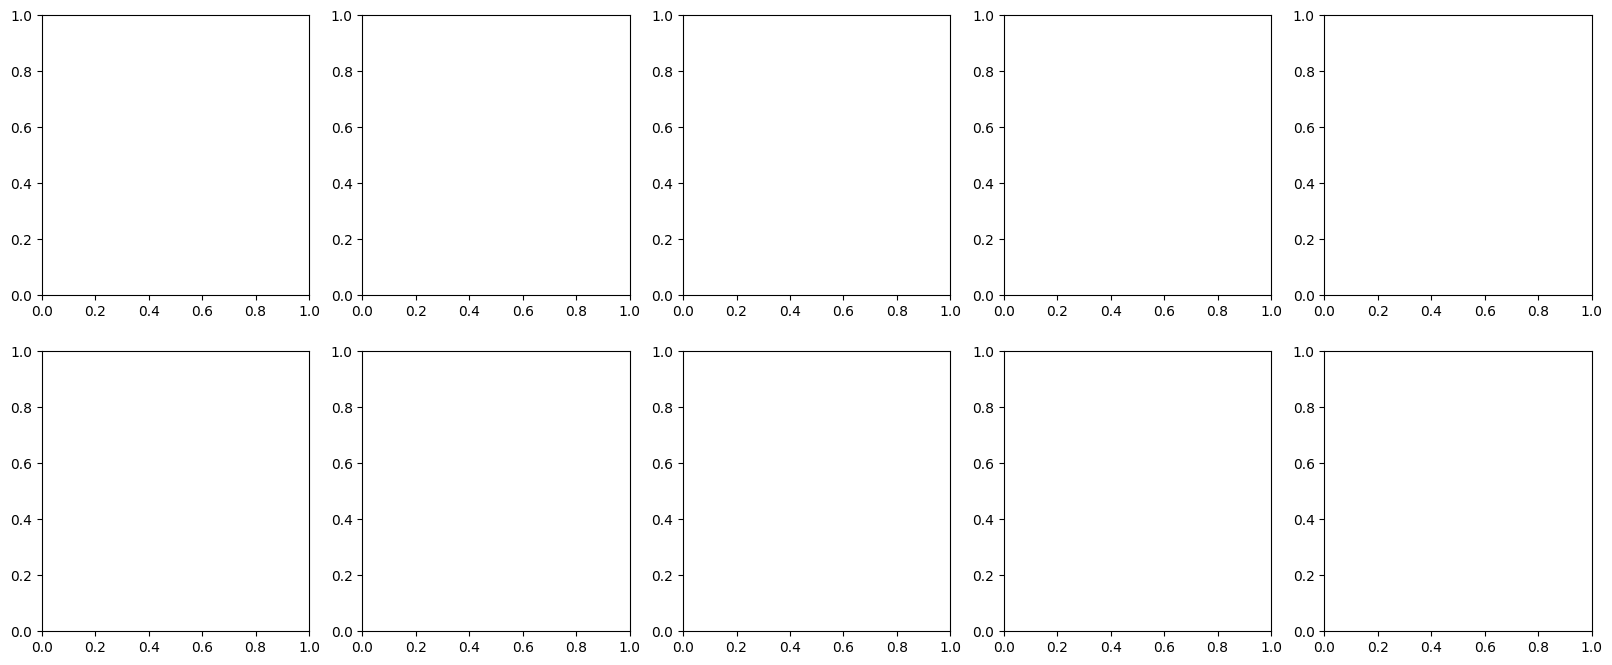

In [ ]:

# Create subplots with the calculated number of rows and 5 columns
fig2, axes2 = plt.subplots(num_rows, countries_per_row, figsize=(20, num_rows * 4))
axes2 = axes2.flatten()

avail_countries_forecasted_data = []

for i,country in enumerate(avail_countries):
    
    pdq = best_pdq_dic[country]
  
    country_df_forecasted = pd.DataFrame(arima_country_forecast(5,country,pdq,axes2[i]))  
    
    # Set the country name as a level in the index
    country_df_forecasted['Country Name'] = country
    country_df_forecasted = country_df_forecasted.set_index('Country Name', append=True)
    
    # Reorder levels so that "Country" comes first
    country_df_forecasted = country_df_forecasted.reorder_levels(['Country Name', country_df_forecasted.index.names[0]])
    
    # Append to list
    avail_countries_forecasted_data.append(country_df_forecasted)

# Concatenate all country data into a single DataFrame
final_df = pd.concat(avail_countries_forecasted_data)

# Rename the value column if necessary
final_df.columns = ['Gini_coefficient_forecast']  # or your preferred name for the value column

# Adjust layout after deleting empty subplots
plt.tight_layout()
plt.show()

for ax in fig2.get_axes():
    # Check if the axis has any data (lines, collections, etc.)
    if not ax.has_data():
        fig2.delaxes(ax)  # Delete the empty axis



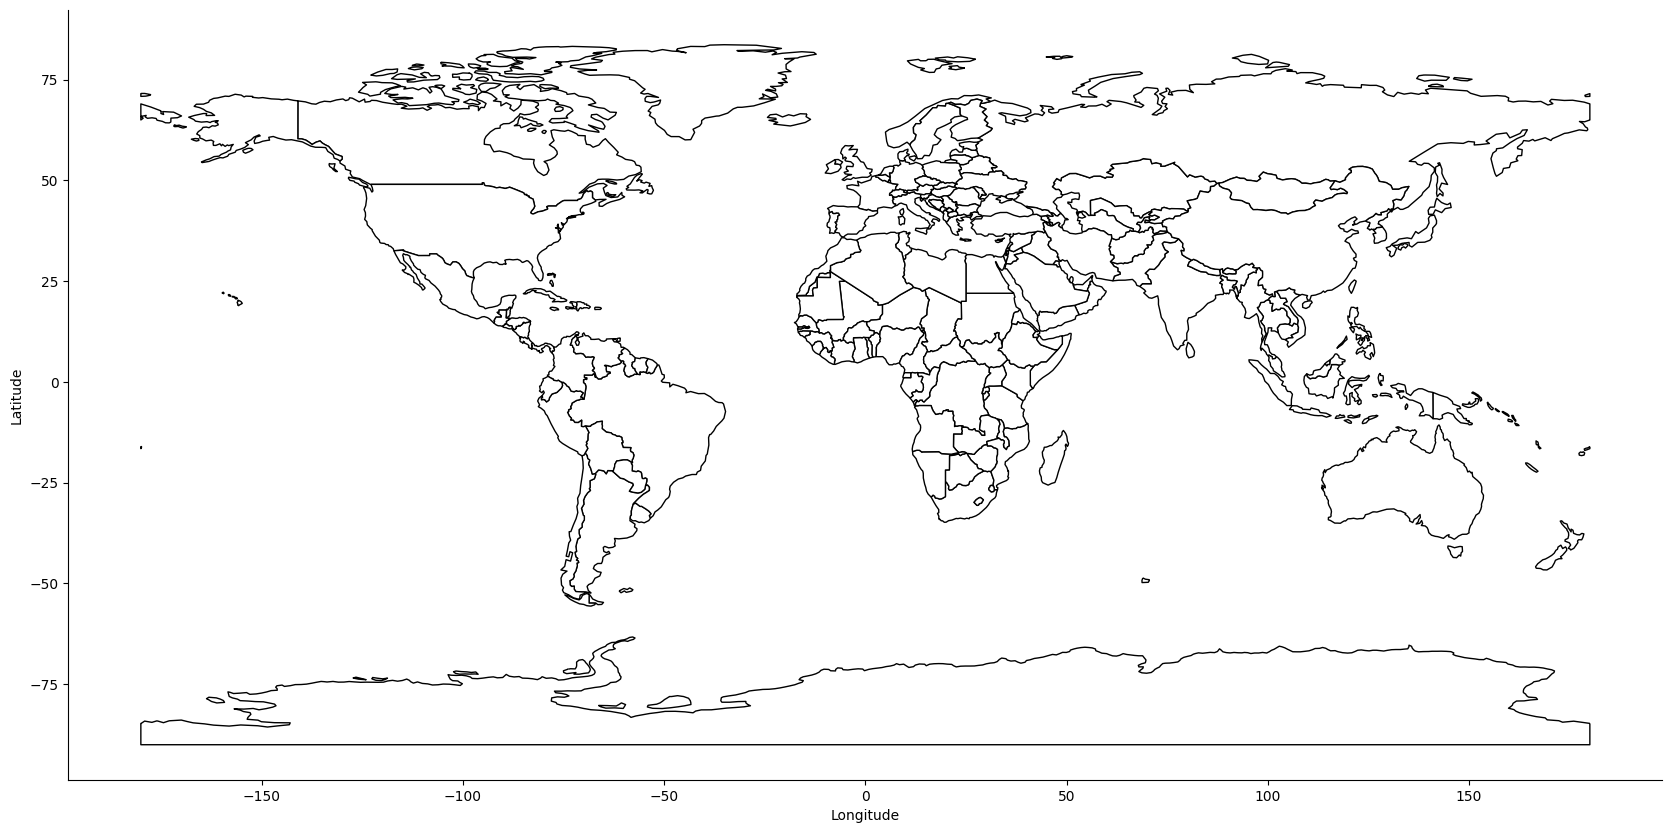

In [ ]:
import geopandas as gpd

# Get World Map data
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = world.set_index("ADM0_A3")
world_columns_req = ["ADMIN", "geometry"]
world_geom = world[world_columns_req]

world_geom.head()

# Plot world map

fig, ax = plt.subplots(figsize=(30,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world_geom.plot(ax=ax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()